<a href="https://colab.research.google.com/github/mcianfrocco/cryoEM-education/blob/main/RELION_motion_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CryoEM processing: Motion correction
Welcome to an interactive notebook to introduce motion correction. Here you will be able to: 

1.   Upload cryoEM movies and perform motion correction using RELION
2.   Adjust parameters in motion correction to observe how it affects the resulting aligned micrograph.



##Why do we collect movies vs. single exposures? 

During cryoEM imaging, samples move within the viterous during the exposure. This is seen very well in [Brilot et. al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322646/) when imaging rotavirus double-layer particles: 

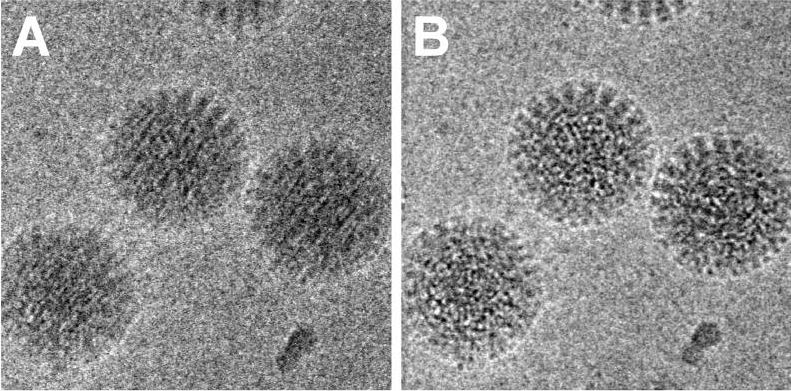


Left: Summed movie (no alignment)
Right: Summed movie after aligning movie frames



# Install RELION & setup environment
The first step needed to run this RELION colab notebook is to compile RELION from source code. By clicking the 'Play' button below, the notebook will:

1.   Install  the appropriate dependencies
2.   Clone RELION code from GitHub repo 
3.   Compile RELION 

This will take ~5 minutes.

In [ ]:
#@title *Run this cell to download & compile RELION*
%%shell
sudo apt install cmake git build-essential mpi-default-bin mpi-default-dev libfftw3-dev libtiff-dev
rm -rf relion/
git clone https://github.com/3dem/relion.git
cd relion/
mkdir build/
cd build
cmake ..
make -j5
pip install mrcfile

In [71]:
#@title *Run this cell to set up Python environment*
#Useful python libraries from Liz Kellogg: https://github.com/kellogg-cryoem/basic/blob/aa0f576aee46416360f7cf296b02aec7b42bfb34/modules/basicEM.py
def fftim(m):
    import numpy as np
    return np.fft.fftshift(np.fft.fft2(m))
def square(m):
    #m is a numpy array
    import numpy as np
    import mrcfile 
    mindim = np.min(m.shape)
    return m[0:mindim,0:mindim]
def gauss2d(sz,sigma,center):
    import numpy as np
    ndx = np.linspace(0,sz,sz)
    [R,C] = np.meshgrid(ndx,ndx);
    return gaussC(R,C,sigma,center)
def gaussC( x,y,sigma,center):
    import numpy as np
    xc = center[0]
    yc = center[1]
    exponent = (np.divide((np.square(x-xc) + np.square(y-yc)),(2*sigma)))
    return np.exp(-exponent)
def circmask(sz,radius,center):
    import numpy as np
    ndx = np.linspace(0,sz,sz)
    [X,Y] = np.meshgrid(ndx,ndx)
    mask = (np.square(X-center[0]) + np.square(Y-center[1])) <= radius**2
    mask = 1*mask.astype(float)
    return mask
def calcPower(im,apix):
    #1. FFT
    fft_im = ((fftim(square(im))))
    #2. crop FFT to 3 Angstrom
    ndx = np.dot( fft_im.shape, apix/3 )
    c = np.dot( fft_im.shape , 0.5 ) 
    s = c - ndx
    e = c + ndx
    s = np.ndarray.astype(s,int)
    e = np.ndarray.astype(e,int)
    fft_im = fft_im[ (s[0]):(e[0]), (s[1]):(e[1])]
    #3. take absolute value of FFT
    fft_im = np.abs(fft_im)
    #steps 4-6 are only for displaying the FFT
    #4. fft the FFT
    fft_squared = fftim(fft_im)
    #5. crop to 512
    c = np.ndarray.astype( np.dot( fft_squared.shape, 0.5 ), int )
    fft_squared = fft_squared[(c[0]-256):(c[0]+256),(c[1]-256):(c[1]+256)]
    #6. inverse the fft(fft) to get the fft
    TheOriginalfft = np.fft.ifft2(np.fft.ifftshift(fft_squared))
    sz = TheOriginalfft.shape
    center = np.dot(sz,0.5)
    #6b. high-pass filter the fft
    sigma = 100000
    hpmask = gauss2d(sz[0],sigma,center)
    hpmaskfft = np.multiply(abs(TheOriginalfft),hpmask)
    #7. mask out central peak
    #gmask=np.abs(np.add( np.dot( gauss2d(sz[0],10,center), -1 ), 1)) 
    cm=np.add( np.dot( circmask(sz[0],10,center), -1), 1)
    #plt.imshow(cm)
    #print(cm[256,256])
    TheOriginalfft = np.multiply(hpmaskfft,cm)
    return TheOriginalfft
def radial_profile(data):
    center = np.dot(data.shape,0.5)
    #from https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile
    y,x = np.indices((data.shape)) # first determine radii of all pixels
    r = np.sqrt((x-center[0])**2+(y-center[1])**2)
    ind = np.argsort(r.flat) # get sorted indices
    print(len(ind))
    sr = r.flat[ind] # sorted radii
    sim = data.flat[ind] # image values sorted by radii
    ri = sr.astype(np.int32) # integer part of radii (bin size = 1)
    # determining distance between changes
    deltar = ri[1:] - ri[:-1] # assume all radii represented
    rind = np.where(deltar)[0] # location of changed radius
    nr = rind[1:] - rind[:-1] # number in radius bin
    csim = np.cumsum(sim, dtype=np.float64) # cumulative sum to figure out sums for each radii bin
    tbin = csim[rind[1:]] - csim[rind[:-1]] # sum for image values in radius bins
    radialprofile = tbin/nr # the answer
    return radialprofile

# Load tutorial data

### Upload movie & gain reference using Google Drive 
You can perform motion correction on any movies you'd like to test. Note: Due to limited memory on Google Colab, we cannot run super-resolution movies for motion correction.

#### Tutorial data 
For tutorial data, you can access T20S movies for motion correction: 

Two movies (.tif):
*    14sep05c_c_00003gr_00014sq_00005hl_00003es.frames_bin2.tif
*    14sep05c_c_00003gr_00014sq_00007hl_00004es.frames_bin2.tif

Gain reference file: 
*   norm-amibox05-0_bin2.mrc

Google Drive link: 

https://drive.google.com/drive/folders/16frnqreSeBfEfnJVXDnDFabk3B4DTkF6?usp=sharing

Tutorial data info: 

*   T20S proteasome (D7 symmetry)
*   PMID: 25760083
*   EMPIAR 10025
*   Pixel size: 1.32 *A*/pixel
*   Accelerating voltage: 300 kV
*   Spherical aberration: 2.7 mm



In [2]:
#@title *Run this cell to connect your Google Drive account*
from google.colab import files
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## OR upload your own data 
You can perform motion correction on any movies you'd like to test. Note: Due to limited memory on Google Colab, we cannot run super-resolution movies for motion correction.

# Sum movie without alignment

To highlight what motion correction does for cryoEM micrographs, let's first see what an unaligned movie looks like in real space and Fourier space.

<Figure size 720x720 with 0 Axes>

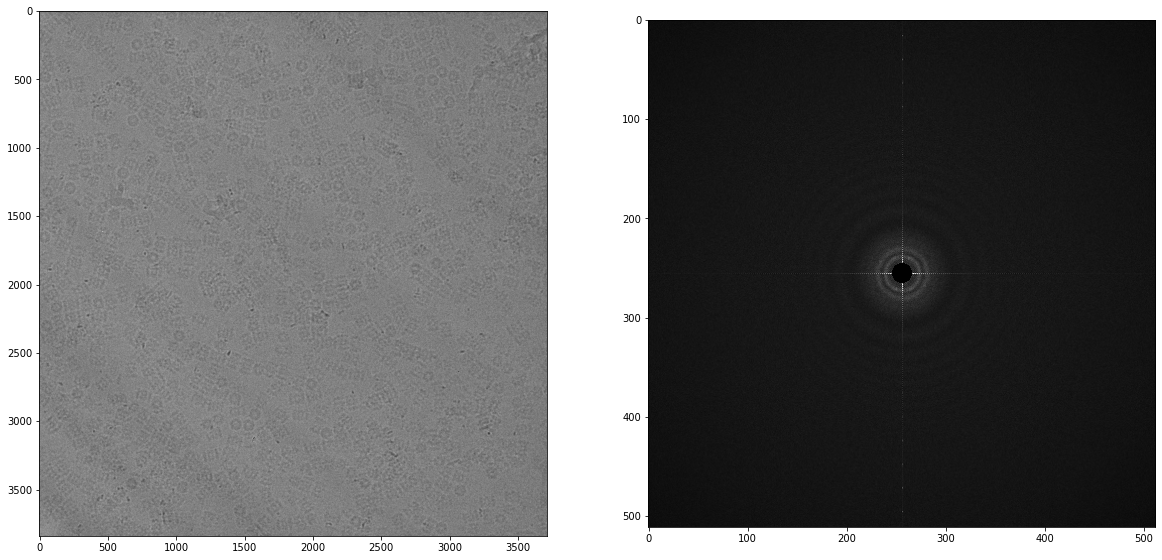

In [105]:
#@title Average frames from movie 
Movie = '/content/drive/MyDrive/Cianfrocco Lab/Member_directories/Michael_Cianfrocco/Active_Projects/Colab/14sep05c_c_00003gr_00014sq_00006hl_00003es.frames_bin2.tif'  #@param {type: "string"}
import numpy as np
import matplotlib
img = io.imread(Movie)
sigma=3

#Average frames 
avgmovie=np.mean(img,axis=0)

#Flip across X axis for consistency of display purposes with RELION
avgmovie=np.flip(avgmovie,0)

#Get image statistics for display purposes. 
avgvalue=np.average(avgmovie)
stdev=np.std(avgmovie)
minval=avgvalue-(sigma*stdev)
maxval=avgvalue+(sigma*stdev)

#calculate power spectrum (squared amplitude of Fourier transform)
pw=calcPower(avgmovie,1)

#Plot output
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20,20)) 
axarr[0].imshow(avgmovie,cmap='gray',vmin=minval,vmax=maxval)
axarr[1].imshow(pw,cmap='gray')


# Gain reference correction 
###What are those lines in the averaged movie above? 
Those lines are from the detector. This means that the **physical pixels** on the detector influence the way the image is displayed, where some pixels on the detector exhibit higher (brighter) or lower responses (darker). There can also be 'dead' pixels and also 'dirt' on the detector, which are other features you do not want present in your micrographs during particle picking & alignment. 

The wavy pattern seen in this averaged movie stack is due to the way that the detectors are manufactured in a process called 'back-thinning.' To increase pixel sensitivity, the chips are thinned using lithography. 

###How do we remove the detector pattern from our movies?
We remove this fixed pattern of the detector through a process called **gain reference correction** where the image of the detector ('gain reference') is removed by subtracting the pattern from the aligned micrograph. 

###Why aren't the movies stored in a gain corrected format?
We store our movies in raw format (i.e., not gain corrected) to save on disk space for the movies. Since we count individual electron events on the detector, each pixel only has whole numbers ('integers') for each pixel on each frame. In this format, the movies are stored as 8-bit values. Then, once gain corrected, the micrographs as stored as 16-bit files. 

When we gain correct, the process of subtracting the gain reference from the aligned micrograph causes the numbers to be stored as numbers with decimal values ('float' values). Changing the original integer values to float values increases the bit-depth of the movie, which increases the file size. This is why we only store movies in integer format whereas micrographs are float format. 

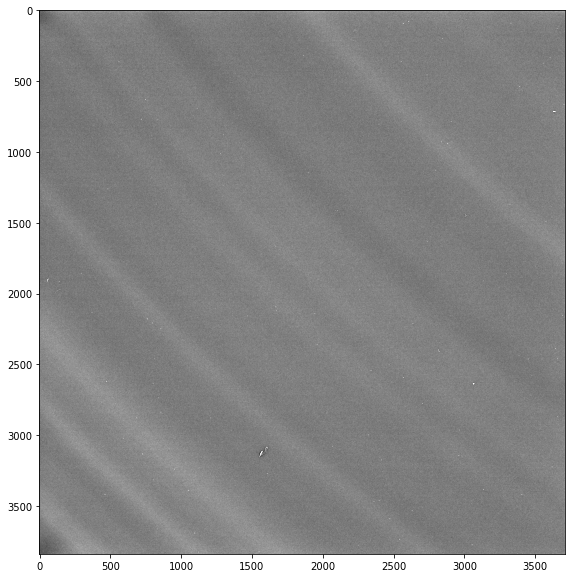

In [116]:
#@title Display gain reference 
Gain_reference_image = '/content/drive/MyDrive/Cianfrocco Lab/Member_directories/Michael_Cianfrocco/Active_Projects/Colab/norm-amibox05-0_bin2.mrc'  #@param {type: "string"}
Scale = 1  #@param {type: "slider", min: 0.1, max: 2,step:0.1}
import mrcfile
import matplotlib.pyplot as plt
import matplotlib

#gainref='/content/drive/MyDrive/Cianfrocco Lab/Member_directories/Michael_Cianfrocco/Active_Projects/Colab/norm-amibox05-0_bin2.mrc'
gainref=mrcfile.open(Gain_reference_image).data
gainref=np.flip(gainref,0)
avg_gain=np.average(gainref)
std_gain=np.std(gainref)
gain_min=avg_gain-(sigma*std_gain)
gain_max=avg_gain+(sigma*std_gain)

#pw=calcPower(gainref,1)
sizex=Scale*10
sizey=Scale*10
plt.rcParams['figure.figsize'] = [sizex, sizey]
plt.imshow(gainref,cmap='gray',vmin=gain_min,vmax=gain_max)
#plt.figure()
#f, axarr = plt.subplots(1,1,figsize=(20,20)) 
#axarr[0].imshow(gainref,cmap='gray')

# Run motion correction 
Run RELION motion correction and visualize resulting micrograph. 

If you connected your Google Drive account you need to enter the full path to the file, including "/content/drive/.../your_file.tif"

Input parameters:

Movie = /content/drive/MyDrive/Cianfrocco Lab/Member_directories/Michael_Cianfrocco/Active_Projects/Colab/14sep05c_c_00003gr_00014sq_00006hl_00003es.frames_bin2.tif
Patch X= 5
Patch Y= 5
B-Factor = 1
Group frames = 1
Gain reference image = /content/drive/MyDrive/Cianfrocco Lab/Member_directories/Michael_Cianfrocco/Active_Projects/Colab/norm-amibox05-0_bin2.mrc
Gain flip = Flip upside down (1)
Gain rotate angle = 90 (1)

Running RELION motion correction...
 Using our own implementation based on MOTIONCOR2 algorithm

 to correct beam-induced motion for the following micrographs: 

  * movies/14sep05c_c_00003gr_00014sq_00006hl_00003es.frames_bin2.tif

Applied rotation and/or flipping to the gain reference and saved to MotionCorr/gain.mrc

 Correcting beam-induced motions using our own implementation ...

000/??? sec ~~(,_,">                                                          [oo]

3.02/3.02 min ............................................................~~(,_,">



<Figure size 1440x1440 with 0 Axes>

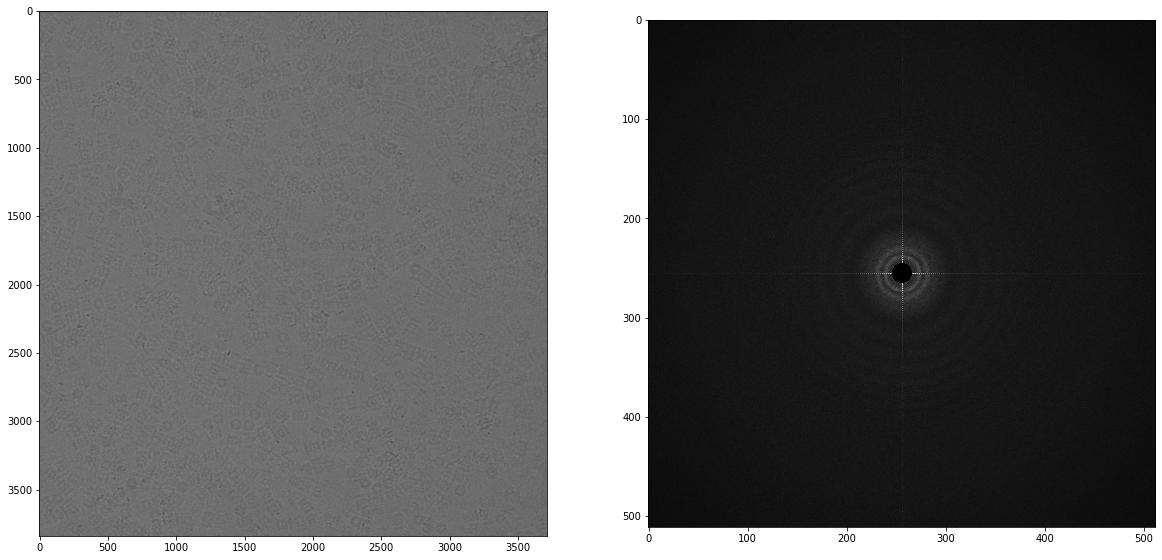

In [115]:
#@title Run motion correction & display aligned micrograph
#@markdown Input parameters for motion correction
#Movie = '/content/drive/MyDrive/Cianfrocco Lab/Member_directories/Michael_Cianfrocco/Active_Projects/Colab/14sep05c_c_00003gr_00014sq_00006hl_00003es.frames_bin2.tif'  #@param {type: "string"}
Patch_X = 5  #@param {type: "slider", min: 1, max: 10}
Patch_Y = 5  #@param {type: "slider", min: 1, max: 10}
B_Factor = 1  #@param {type: "slider", min: 1, max: 1000}
Group_frames = 1  #@param {type: "slider", min: 1, max: 100}
#Binning_factor = 2 #@param {type: "slider", min: 1, max: 6}
#@markdown Gain reference correction options
#gainref = ''  #@param {type: "string"}
Skip_gain_correction = False #@param {type:"boolean"}
Gain_rotate_angle = 90 #@param {type: "slider", min: 0, max: 270,step:90}
Gain_flip = 'Flip upside down' #@param ["None", "Flip upside down", "Flip left to right"] {allow-input: true}

#Import basic libraries 
import subprocess
import sys
import linecache
#Import library to read MRC files: mrcfile
import mrcfile
#Import python plotting software
import matplotlib.pyplot as plt
import matplotlib

#Error check to see if gain reference is .mrc (if uploaded)
if Skip_gain_correction is False:
   if Gain_reference_image.split('.')[-1] != 'mrc':
    print("Error: Gain reference file must be in .mrc format")
    sys.exit()
if '/content/' in Movie: 
    Movie=Movie
else:
    Movie='/content/'+Movie

#Print parameters back to user to confirm parameter choice was parsed correctly
print('Input parameters:\n')
print('Movie = %s' %(Movie)) 
print('Patch X= %i' %(Patch_X))
print('Patch Y= %i' %(Patch_Y))
print('B-Factor = %i' %(B_Factor))
print('Group frames = %i' %(Group_frames))

#Hard coding binning factor=1 for now
Binning_factor = 1

#Format gain reference choices into '0,1,2, etc'
if Skip_gain_correction is False:
    Gain_rot_value=0
    if Gain_rotate_angle == 90:
        Gain_rot_value=1
    if Gain_rotate_angle == 180:
        Gain_rot_value=2
    if Gain_rotate_angle == 270:
        Gain_rot_value=3
    Gain_flip_value =0
    if Gain_flip == 'Flip upside down':
      Gain_flip_value =1
    if Gain_flip == 'Flip left to right':
      Gain_flip_value = 2
    if '/content' in Gain_reference_image: 
        Gain_reference_image=Gain_reference_image
    else: 
        Gain_reference_image='/content/'+Gain_reference_image
    gain_ref_cmd='--gainref "%s" --gain_flip %i' %(Gain_reference_image,Gain_flip_value)
    print('Gain reference image = %s' %(Gain_reference_image))
    print('Gain flip = %s (%i)' %(Gain_flip,Gain_flip_value))
    print('Gain rotate angle = %s (%i)' %(Gain_rotate_angle,Gain_rot_value))
if len(Gain_reference_image) == 0: 
    gain_ref_cmd=''
    print('No gain reference file provided')

print('\nRunning RELION motion correction...')

#Prepare command for running RELION into shell command
cmd='''rm -rf relion-testing 
mkdir relion-testing 
cd relion-testing/
mkdir MotionCorr
mkdir movies/
cp "%s" movies/%s
ls movies/ > info.txt
/content/relion/build/bin/relion_image_handler --i movies/%s --stats > info.txt''' %(Movie,Movie.split('/')[-1],Movie.split('/')[-1])
subprocess.Popen(cmd,shell=True).wait()

#Get stat info
#line=linecache.getline('/content/relion-testing/info.txt',1)
#print(line.split())
#sys.exit()

cmd='''cd relion-testing/
/content/relion/build/bin/relion_run_motioncorr --i 'movies/*.tif' --grouping_for_ps 38 --o MotionCorr --patch_x %i --patch_y %i --group_frames %i --bfactor %i --bin_factor %i --use_own --angpix 0.66 --voltage 300 %s >> run.out 2>>run.err''' %(Patch_X,Patch_Y,Group_frames,B_Factor,Binning_factor,gain_ref_cmd)
#print(cmd)
subprocess.Popen(cmd,shell=True).wait()

#Specify micrograph path:
input_micrograph='/content/relion-testing/MotionCorr/movies/14sep05c_c_00003gr_00014sq_00006hl_00003es_frames_bin2.mrc'

#print output
for line in open('/content/relion-testing/run.out','r'):
  print(line)

#Print error if motion correction didn't run
if not os.path.exists(input_micrograph):
  print('Error: Output micrograph was not generated. See error below')
  for line in open('/content/relion-testing/run.err','r'):
      print(line)
  sys.exit()

#Read micrograph into python-readable array:
micrograph_array=mrcfile.open(input_micrograph).data
print('Reading micrograph into NumPy array...\n')

#Print micrograph info
print('Micrograph dimensions (X,Y): %s,%s' %(mrcfile.open(input_micrograph).data.shape[0],mrcfile.open(input_micrograph).data.shape[1]))
print('Micrograph pixel size (reading from MRC header): %0.3fA/pix' %(mrcfile.open(input_micrograph).voxel_size['x']))

#Display micrograph
pw=calcPower(micrograph_array,1)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20,20)) 
axarr[0].imshow(micrograph_array,cmap='gray')
axarr[1].imshow(pw,cmap='gray')

#matplotlib.rcParams['figure.figsize'] = [15, 15]
#plt.imshow(micrograph_array,cmap='gray')
#im=mrcfile.open(input_micrograph).data
#show_power(micrograph_array,1)